In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

healthDataRaw = pd.read_csv('cardio_train.csv')

# assuming your DataFrame is named df_clean
rename_map = {
    'age (in years)':                                                        'age_years',
    'height (in m)':                                                         'height_m',
    'weight (in kg)':                                                        'weight_kg',
    'bmi (body mass index)':                                                 'body_mass_index',
    'ap_hi (systolic blood pressure)':                                       'systolic_bp',
    'ap_lo (diastolic blood pressure)':                                      'diastolic_bp',
    'map (mean arterial pressure)':                                          'mean_arterial_pressure',
    'pp (pulse pressure)':                                                   'pulse_pressure',
    'cholesterol (1- normal, 2 - above normal, 3- well above normal)':       'cholesterol_level',
    'gluc (1- normal, 2 - above normal, 3- well above normal)':              'glucose_level',
    'gender( 1 for Women, 2 for Men)':                                       'gender',
    'smoke (0 - does not smoke, 1 - smokes)':                                'smoking_status',
    'alco (0 - does not alcohol, 1 - consumes alcohol)':                     'alcohol_consumption',
    'active (0 - does not exercise, 1 - exercises)':                         'physical_activity',
    'cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)': 'cardiovascular_disease'
}
healthData = healthDataRaw.rename(columns=rename_map)

healthDataClean = healthData.copy()

# removing entries with values less than 0 for blood pressure, pulse pressure and arterial pressure (medically impossible values)
healthDataClean = healthDataClean[
                        (healthDataClean['systolic_bp'] > 0) &
                        (healthDataClean['diastolic_bp'] > 0) &
                        (healthDataClean['pulse_pressure'] > 0) &
                        (healthDataClean['mean_arterial_pressure'] > 0)
]

# reset index of dataframe as we removed some rows
healthDataClean = healthDataClean.reset_index(drop=True)

# define variable types
continuous_cols = ['age_years', 'height_m', 'weight_kg', 'body_mass_index', 'systolic_bp', 'diastolic_bp', 'mean_arterial_pressure', 'pulse_pressure']
binary_cols = ['smoking_status', 'alcohol_consumption', 'physical_activity', 'gender']
ordinal_cols = ['cholesterol_level', 'glucose_level']

healthDataRemovedOutliers = healthDataClean.copy() #just in case we need healthDataClean dataframe

# remove outliers for continuous variables
for col in continuous_cols:
    Q1 = healthDataClean[col].quantile(0.25)
    Q3 = healthDataClean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    healthDataRemovedOutliers = healthDataRemovedOutliers[healthDataRemovedOutliers[col].between(lower, upper)]

# split into features(X) and target(y)
X_df = healthDataRemovedOutliers[continuous_cols + binary_cols + ordinal_cols]
y = healthDataRemovedOutliers['cardiovascular_disease']

# build the transformer: MinMaxScale continuous and binary variables, OneHotEncode ordinal columns
preprocessor = ColumnTransformer(transformers=[
    ('scale', MinMaxScaler(), continuous_cols + binary_cols),
    ('ohe',   OneHotEncoder(drop='first', sparse_output=False), ordinal_cols), #drop='first' to avoid collinearity and remove redundancy, sparse=False makes the output a regular array
])
X_array = preprocessor.fit_transform(X_df)

# turn X_array back into a DataFrame with original names
ohe_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(ordinal_cols)
all_feature_names = continuous_cols + binary_cols + list(ohe_names)
df_encoded_features = pd.DataFrame(X_array, columns=all_feature_names, index=healthDataRemovedOutliers.index)

# Now df_encoded_features is the feature matrix and y is the target vector

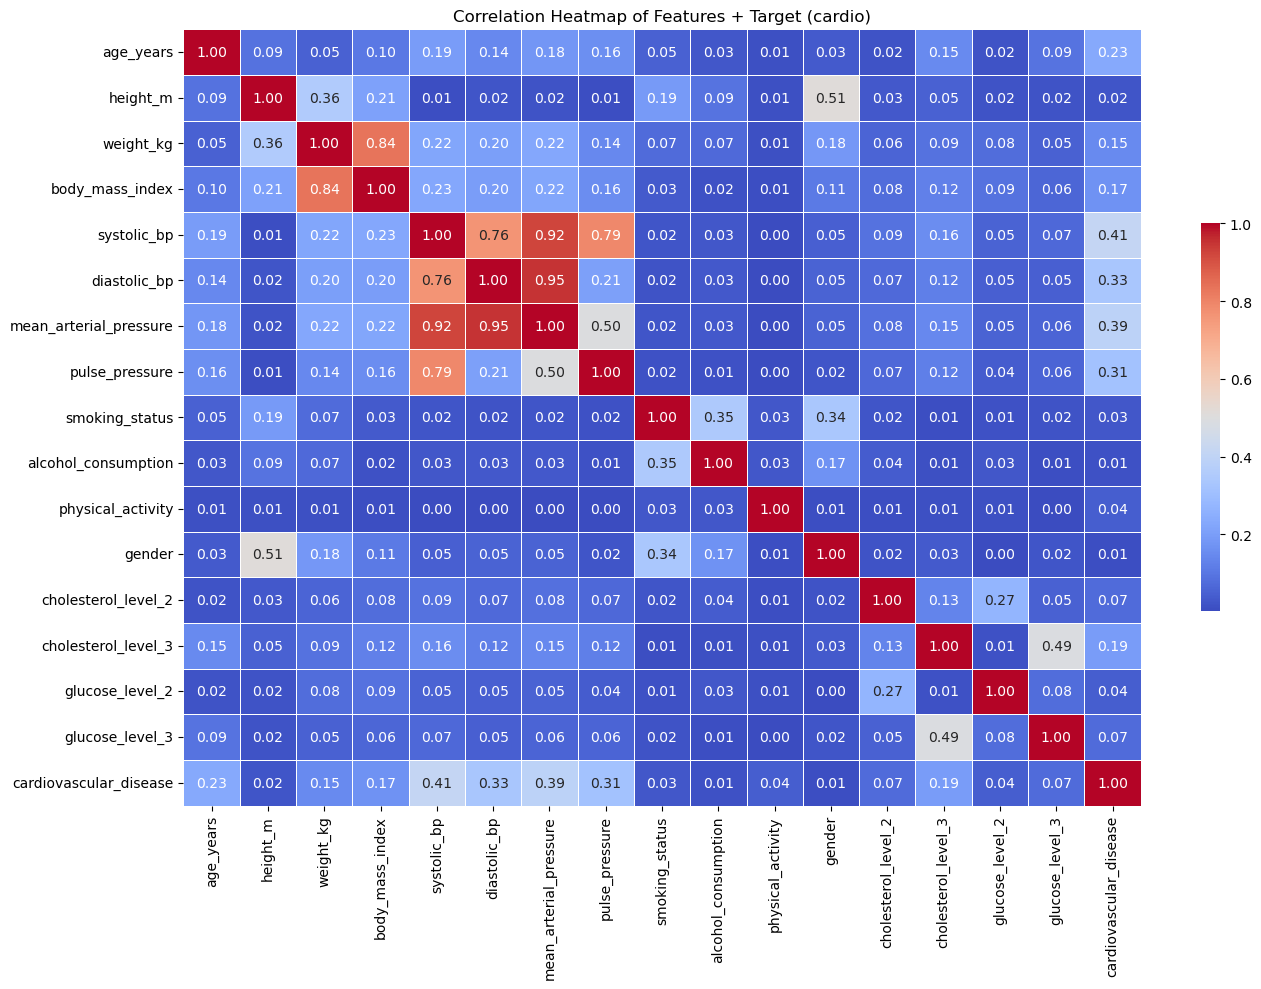

In [3]:
# assume df_encoded_features and y (a pd.Series) are already defined
df_with_target = df_encoded_features.copy()
df_with_target['cardiovascular_disease'] = y

# compute absolute correlations including the target
corr_matrix = df_with_target.corr().abs()

# mask the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 10))
sb.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": .5}
)
plt.title('Correlation Heatmap of Features + Target (cardio)')
plt.tight_layout()
plt.show()

In [4]:
# === Feature Selection: keep only the 8 chosen predictors ===
selected_features = [
    'age_years',
    'body_mass_index',
    'systolic_bp',
    'diastolic_bp',
    'cholesterol_level_2',
    'cholesterol_level_3',
    'glucose_level_2',
    'glucose_level_3'
]

df_selected = df_encoded_features[selected_features]

# Now split into train/test using only the selected features
X_train, X_test, y_train, y_test = train_test_split(
    df_selected, y,
    test_size=0.2,
    random_state=42
)

In [5]:
# 1) Logistic Regression
from sklearn.linear_model import LogisticRegression

results = []

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
rec    = recall_score(y_test, y_pred)
y_score= model.predict_proba(X_test)[:,1]
roc    = roc_auc_score(y_test, y_score)

results.append({
    'model':'Logistic Regression',
    'accuracy': acc,
    'recall':   rec,
    'roc_auc':  roc
})
print(results[-1])

{'model': 'Logistic Regression', 'accuracy': 0.711922569291685, 'recall': 0.6105302464525766, 'roc_auc': 0.7729703210929187}


In [6]:
# 2) Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
rec    = recall_score(y_test, y_pred)
y_score= model.predict_proba(X_test)[:,1]
roc    = roc_auc_score(y_test, y_score)

results.append({
    'model':'GaussianNB',
    'accuracy': acc,
    'recall':   rec,
    'roc_auc':  roc
})
print(results[-1])


{'model': 'GaussianNB', 'accuracy': 0.697228332600088, 'recall': 0.5795369678864825, 'roc_auc': 0.7571096212290973}


In [7]:
# 3) k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
rec    = recall_score(y_test, y_pred)
y_score= model.predict_proba(X_test)[:,1]
roc    = roc_auc_score(y_test, y_score)

results.append({
    'model':'kNN',
    'accuracy': acc,
    'recall':   rec,
    'roc_auc':  roc
})
print(results[-1])

{'model': 'kNN', 'accuracy': 0.6834139903211615, 'recall': 0.65067214339059, 'roc_auc': 0.730619452325122}


In [8]:
# 4) SVM (RBF kernel)
from sklearn.svm import SVC

model = SVC(probability=True, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
rec    = recall_score(y_test, y_pred)
y_score= model.predict_proba(X_test)[:,1]
roc    = roc_auc_score(y_test, y_score)

results.append({
    'model':'SVM (RBF)',
    'accuracy': acc,
    'recall':   rec,
    'roc_auc':  roc
})
print(results[-1])

{'model': 'SVM (RBF)', 'accuracy': 0.7131544214694236, 'recall': 0.5916728902165795, 'roc_auc': 0.7693686163560236}


In [9]:
# 5) Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
rec    = recall_score(y_test, y_pred)
y_score= model.predict_proba(X_test)[:,1]
roc    = roc_auc_score(y_test, y_score)

results.append({
    'model':'Decision Tree',
    'accuracy': acc,
    'recall':   rec,
    'roc_auc':  roc
})
print(results[-1])

{'model': 'Decision Tree', 'accuracy': 0.6211174659040916, 'recall': 0.6045556385362211, 'roc_auc': 0.6200844985944036}


In [10]:
# 6) Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
rec    = recall_score(y_test, y_pred)
y_score= model.predict_proba(X_test)[:,1]
roc    = roc_auc_score(y_test, y_score)

results.append({
    'model':'Random Forest',
    'accuracy': acc,
    'recall':   rec,
    'roc_auc':  roc
})
print(results[-1])

{'model': 'Random Forest', 'accuracy': 0.6804223493180819, 'recall': 0.6405899925317401, 'roc_auc': 0.7370302058736641}


In [11]:
# 7) XGBoost Classifier
# !pip install xgboost if not installed
from xgboost import XGBClassifier

model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
rec    = recall_score(y_test, y_pred)
y_score= model.predict_proba(X_test)[:,1]
roc    = roc_auc_score(y_test, y_score)

results.append({
    'model':'XGBoost',
    'accuracy': acc,
    'recall':   rec,
    'roc_auc':  roc
})
print(results[-1])

{'model': 'XGBoost', 'accuracy': 0.7132424109106907, 'recall': 0.635175504107543, 'roc_auc': 0.775351551338663}


In [12]:
# 8) Multi-layer Perceptron (MLP)
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(200,), max_iter=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
rec    = recall_score(y_test, y_pred)
y_score= model.predict_proba(X_test)[:,1]
roc    = roc_auc_score(y_test, y_score)

results.append({
    'model':'MLP',
    'accuracy': acc,
    'recall':   rec,
    'roc_auc':  roc
})
print(results[-1])

{'model': 'MLP', 'accuracy': 0.719313682358117, 'recall': 0.6398431665421956, 'roc_auc': 0.7819013171803161}


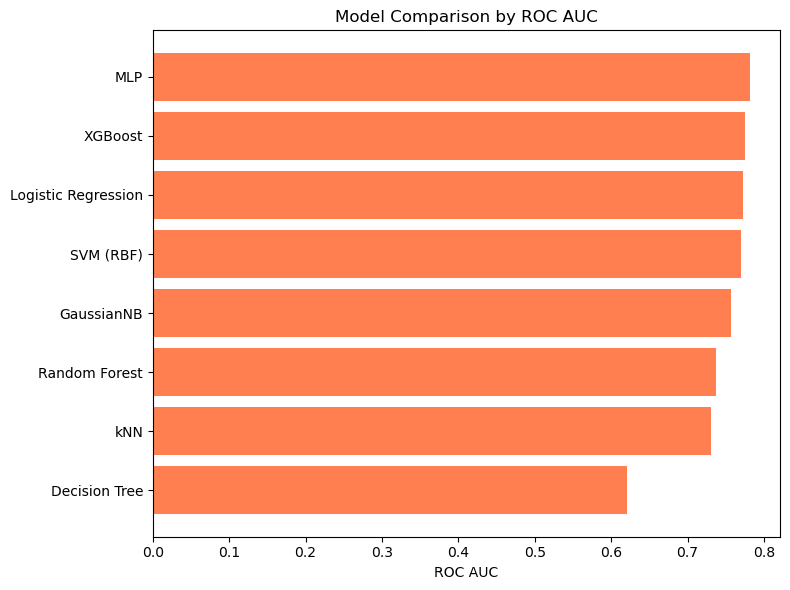

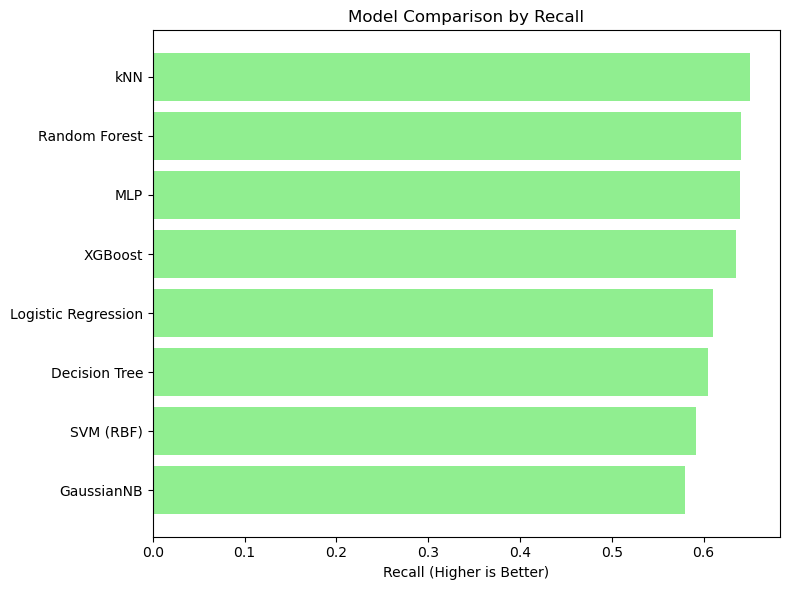

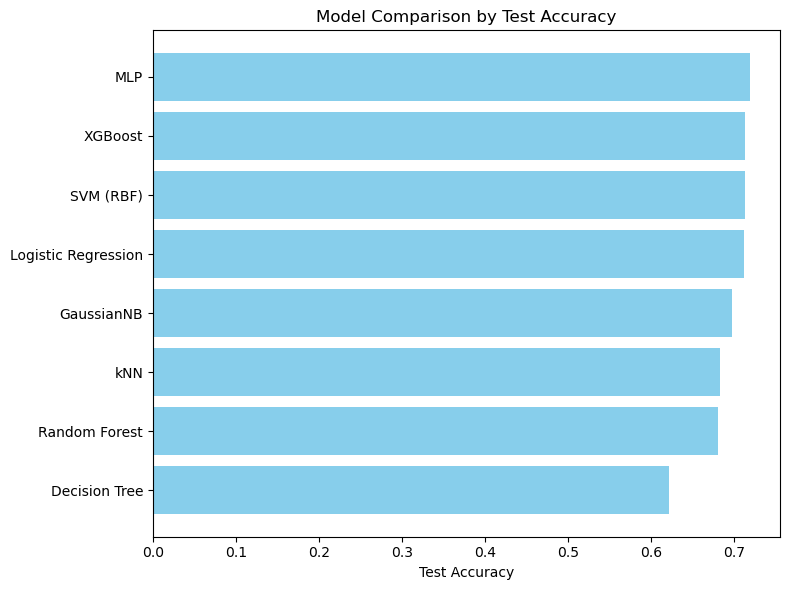

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert your accumulated results into a DataFrame
df = pd.DataFrame(results)

# 1) ROC AUC plot
#   filter out models without an AUC score
df_roc = df[df['roc_auc'].notnull()].sort_values('roc_auc', ascending=True)
plt.figure(figsize=(8, 6))
plt.barh(df_roc['model'], df_roc['roc_auc'], color='coral')
plt.xlabel('ROC AUC')
plt.title('Model Comparison by ROC AUC')
plt.tight_layout()
plt.show()

# 2) Recall plot
df_rec = df.sort_values('recall', ascending=True)
plt.figure(figsize=(8, 6))
plt.barh(df_rec['model'], df_rec['recall'], color='lightgreen')
plt.xlabel('Recall (Higher is Better)')
plt.title('Model Comparison by Recall')
plt.tight_layout()
plt.show()

# 3) Test Accuracy plot
df_acc = df.sort_values('accuracy', ascending=True)
plt.figure(figsize=(8, 6))
plt.barh(df_acc['model'], df_acc['accuracy'], color='skyblue')
plt.xlabel('Test Accuracy')
plt.title('Model Comparison by Test Accuracy')
plt.tight_layout()
plt.show()

In [14]:
# 9) Voting Classifier (soft voting)
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

model = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('xgb', XGBClassifier(eval_metric='logloss', random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(200,), max_iter=200, random_state=42))
    ],
    voting='soft'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
rec    = recall_score(y_test, y_pred)
y_score= model.predict_proba(X_test)[:,1]
roc    = roc_auc_score(y_test, y_score)

results.append({
    'model':'Voting Soft Ensemble',
    'accuracy': acc,
    'recall':   rec,
    'roc_auc':  roc
})
print(results[-1])

{'model': 'Voting Soft Ensemble', 'accuracy': 0.7180818301803783, 'recall': 0.6340552651232263, 'roc_auc': 0.7815463293732541}


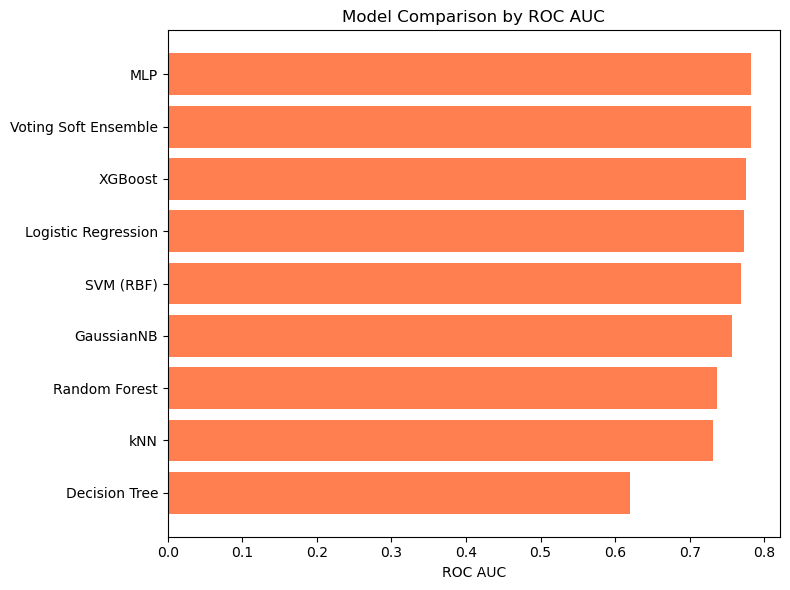

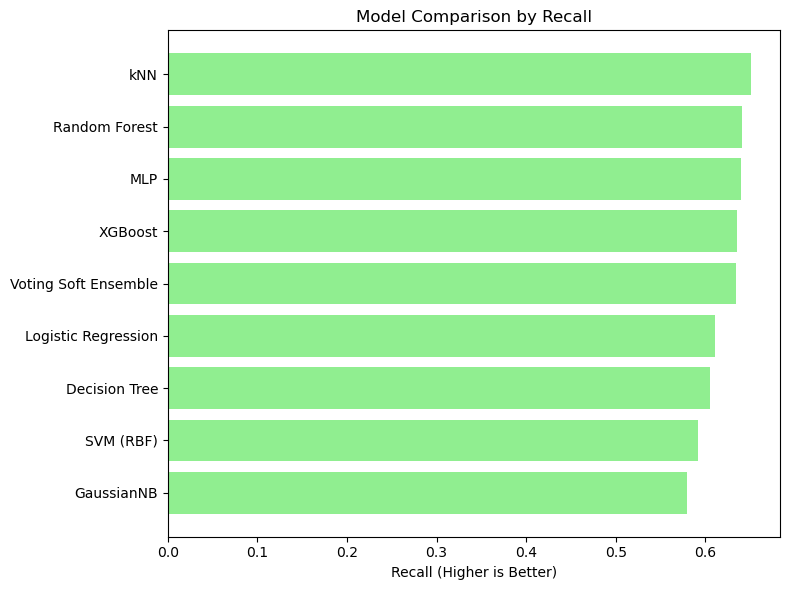

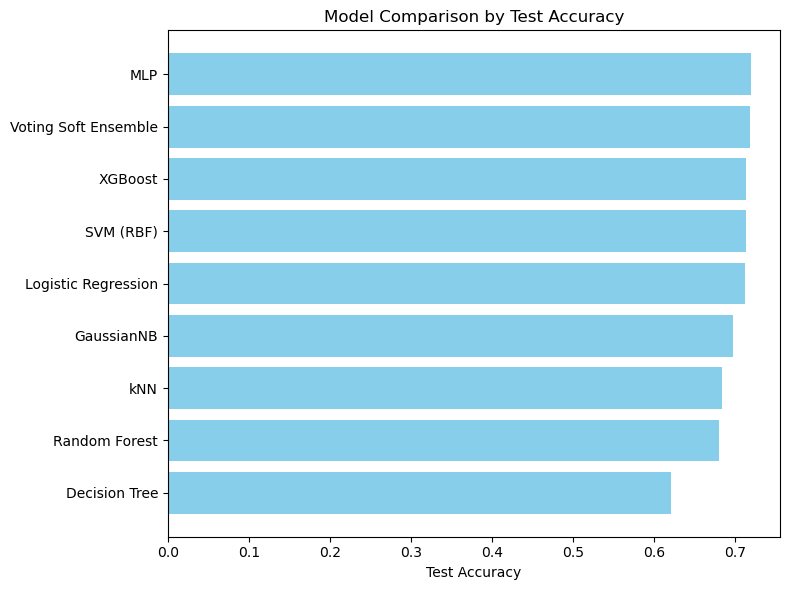

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert your accumulated results into a DataFrame
df = pd.DataFrame(results)

# 1) ROC AUC plot
#   filter out models without an AUC score
df_roc = df[df['roc_auc'].notnull()].sort_values('roc_auc', ascending=True)
plt.figure(figsize=(8, 6))
plt.barh(df_roc['model'], df_roc['roc_auc'], color='coral')
plt.xlabel('ROC AUC')
plt.title('Model Comparison by ROC AUC')
plt.tight_layout()
plt.show()

# 2) Recall plot
df_rec = df.sort_values('recall', ascending=True)
plt.figure(figsize=(8, 6))
plt.barh(df_rec['model'], df_rec['recall'], color='lightgreen')
plt.xlabel('Recall (Higher is Better)')
plt.title('Model Comparison by Recall')
plt.tight_layout()
plt.show()

# 3) Test Accuracy plot
df_acc = df.sort_values('accuracy', ascending=True)
plt.figure(figsize=(8, 6))
plt.barh(df_acc['model'], df_acc['accuracy'], color='skyblue')
plt.xlabel('Test Accuracy')
plt.title('Model Comparison by Test Accuracy')
plt.tight_layout()
plt.show()